In [1]:
import os
import glob
import pickle
import numpy as np
from mne import viz
from scipy import io, stats
from matplotlib import colors, pyplot as plt

In [2]:
CAF_DOSE = 200
SIGNIFICANT_P = 0.05

PROJECT_PATH = '..\\data'

STAGES = ['AWA', 'AWSL', 'NREM', 'REM']

In [3]:
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
scores_list = []
for path in glob.glob(f'..\\results\\scores{CAF_DOSE}\\*'):
    if 'combined' in path:
        with open(path, 'rb') as file:
            scores_list.append(pickle.load(file))

In [5]:
acc_avg = {}
significant = {}
pvalues = {}
for stage in STAGES:
    acc_avg[stage] = {}
    significant[stage] = {}
    pvalues[stage] = {}
    
    for score in scores_list:
        for feature in score[stage].keys():
            acc = np.array([curr[0] for curr in score[stage][feature]])
            curr_p = np.array([curr[2] for curr in score[stage][feature]])
            
            if feature in acc_avg[stage]:
                acc_avg[stage][feature] += acc / len(scores_list)
                pvalues[stage][feature].append(curr_p)
            else:
                acc_avg[stage][feature] = acc / len(scores_list)
                pvalues[stage][feature] = [curr_p]
        
    for feature in score[stage].keys():
        pvalues[stage][feature] = np.array(pvalues[stage][feature])
        significant[stage][feature] = np.empty(pvalues[stage][feature].shape[1])
        for i in range(len(pvalues[stage][feature])):
            significant[stage][feature][i] = stats.combine_pvalues(pvalues[stage][feature][:,i])[1]

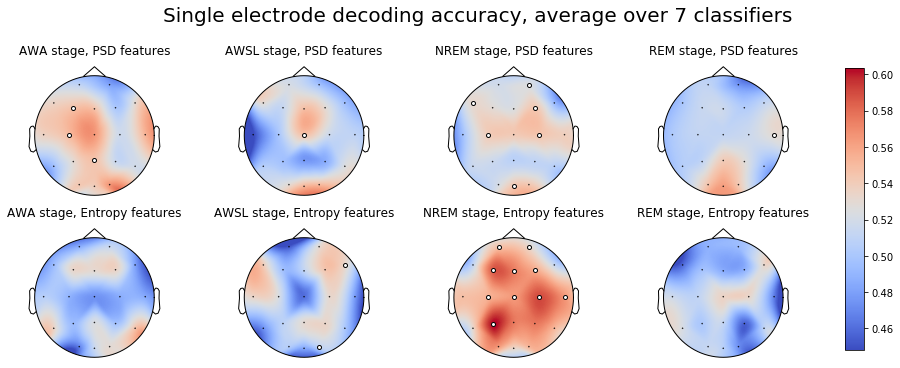

In [6]:
colormap = 'coolwarm'

plt.figure(figsize=(18, 5))
plt.suptitle(f'Single electrode decoding accuracy, average over {len(scores_list)} classifiers', y=1.1, fontsize=20)

all_scores = [[acc_avg[stage][feature] for feature in acc_avg[stage].keys()] for stage in STAGES]
vmin = np.min(all_scores)
vmax = np.max(all_scores)

axes = []
subplot_index = 1
for feature in acc_avg['AWA'].keys():
    for stage in STAGES:
        axes.append(plt.subplot(2, 4, subplot_index))
        plt.title(f'{stage} stage, {feature} features')
        
        mask = significant[stage][feature] < SIGNIFICANT_P
        acc = acc_avg[stage][feature]
        viz.plot_topomap(acc, sensor_pos, mask=mask, cmap=colormap, vmin=vmin, vmax=vmax, contours=False, show=False)
        subplot_index += 1

norm = colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=axes, shrink=0.95, aspect=15)
plt.show()